#LSTM STOCK PREDICTION

In [62]:
# uploading file to colab 
from google.colab import files
uploaded = files.upload()

Saving tsla.us.txt to tsla.us (1).txt


In [63]:
from sklearn import metrics # importing for evaluating models
from sklearn.model_selection import train_test_split # importing for splitting the data
from sklearn.preprocessing import MinMaxScaler # for normalization in the lstm model
import matplotlib.pyplot as plt # for plots
import numpy as np # for general math calculations
from numpy import linalg as la # for linear algebra calculations
import pandas as pd # for handling datasets
from keras.models import Sequential # for creating a neural network 
from keras.layers import Dense, Dropout, LSTM # for creating the LSTM model

In [65]:
stock = "tsla.us.txt"
df = pd.read_csv(stock)

In [67]:
# for the LSTM NN we want to scale our data from 0 to 1 using the min-max scaler
scaler = MinMaxScaler(feature_range=(0, 1)) # creating a minmax scaler object that will scale our features in the range (0,1)
data = scaler.fit_transform(df["Close"].values.reshape(-1,1)) # scaling our data from in the range (0, 1)
train_len = int( len(data) * 0.7 )

#splitting the data 
train_data = data[0: train_len]
test_data = data[train_len::]

# =====================================================
#                    TRAINING MODEL
# =====================================================

pred_days = 100 # how many days do we want to look in the past

x_train_NN = []
y_train_NN = []

x_test_NN = []
y_test_NN = []

# creating the train data by putting in training the 60 days prior to the one we want to predict
for x in range(pred_days, len(train_data)):
  x_train_NN.append(train_data[x - pred_days:x, 0])
  y_train_NN.append(train_data[x, 0])

for x in range(pred_days, len(test_data)):
  x_test_NN.append(test_data[x - pred_days:x, 0])
  y_test_NN.append(test_data[x, 0])

# making them arrays and reshaping them so as to work with nn's
x_train_NN = np.array(x_train_NN)
y_train_NN = np.array(y_train_NN)

x_train_NN = np.reshape(x_train_NN, (x_train_NN.shape[0], x_train_NN.shape[1], 1))

x_test_NN = np.array(x_test_NN)
y_test_NN = np.array(y_test_NN)

x_test_NN = np.reshape(x_test_NN, (x_test_NN.shape[0], x_test_NN.shape[1], 1))

# building the model 
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_NN.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # prediction 

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train_NN, y_train_NN, epochs=100, batch_size=32)

Epoch 1/100
38/38 [==============================] - 12s 164ms/step - loss: 0.0198
Epoch 2/100
38/38 [==============================] - 8s 211ms/step - loss: 0.0023
Epoch 3/100
38/38 [==============================] - 6s 162ms/step - loss: 0.0024
Epoch 4/100
38/38 [==============================] - 6s 149ms/step - loss: 0.0022
Epoch 5/100
38/38 [==============================] - 6s 148ms/step - loss: 0.0018
Epoch 6/100
38/38 [==============================] - 5s 144ms/step - loss: 0.0021
Epoch 7/100
38/38 [==============================] - 6s 145ms/step - loss: 0.0019
Epoch 8/100
38/38 [==============================] - 6s 145ms/step - loss: 0.0018
Epoch 9/100
38/38 [==============================] - 6s 145ms/step - loss: 0.0021
Epoch 10/100
38/38 [==============================] - 6s 147ms/step - loss: 0.0021
Epoch 11/100
38/38 [==============================] - 6s 147ms/step - loss: 0.0016
Epoch 12/100
38/38 [==============================] - 6s 145ms/step - loss: 0.0016
Epoch 13/100

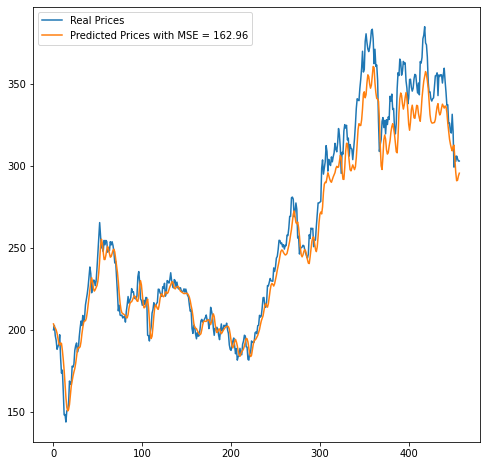

In [68]:
# =====================================================
#                    TESTING MODEL
# =====================================================

pred_prices = model.predict(x_test_NN)
real_prices = y_test_NN

pred_prices = scaler.inverse_transform(pred_prices) # denormalizing the predicted prices
real_prices = real_prices.reshape((len(real_prices),1))
real_prices = scaler.inverse_transform(real_prices) # denormalizing the real prices

mse = metrics.mean_squared_error(real_prices, pred_prices)
                                 
# Plotting the data
plt.figure(figsize=(8,8))

plt.plot(real_prices, label="Real Prices")
plt.plot(pred_prices, label="Predicted Prices with MSE = {0:.2f}".format(mse))
plt.legend()
plt.show()

In [69]:
print("Mean Squared Error: {0:.2f}$".format(metrics.mean_squared_error(real_prices, pred_prices)) ) # the mean squared error

Mean Squared Error: 162.96$


In [70]:
# Creating a virtual account too see if we would win money with those preds
def VR_trade(opens, closes, preds, start_acc=1000, thresh=0):
  acc = start_acc
  changes = []

  for i in range(len(preds)):
    if (preds[i] - opens[i])/opens[i] >= thresh:
      acc += acc*(closes[i] - opens[i])/opens[i]
    changes.append(acc)

  changes = np.array(changes)

  # this is the money we would have won without using the model 
  invest_total = start_acc + start_acc * ( closes[-1] - opens[0] ) / opens[0] 

  print("Investing Total : ", round(invest_total,2), \
        str(round((invest_total - start_acc)/start_acc*100,1)) + "%")
   
  print("Algo-Trading Total : ", round(acc,2), \
        str(round((acc - start_acc)/start_acc*100,1)) + "%")
  

  plt.figure(figsize=(8,8))
  plt.plot(range(len(changes)), changes, label="Strategy outcome = " + str(round((acc - start_acc)/start_acc*100,1)) + "%")
  plt.title("LSTM Strategy for " + stock)
  plt.legend()
  plt.savefig(stock + "NN.png")
  plt.show()
  
   

Investing Total :  1311.65 31.2%
Algo-Trading Total :  1034.71 3.5%


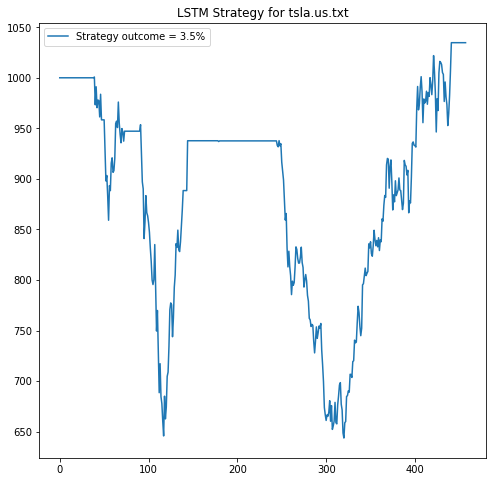

In [71]:
opens = df["Open"][train_len:].values
closes = df["Close"][train_len:].values
VR_trade(opens, closes, pred_prices)